## **Predictive Analysis Plan for the Titanic Dataset**  

1. Define the Problem Statement
2. Data Preparation for Modeling
3. Model Selection
4. Model Training & Evaluation
5. Hyperparameter Tuning
6. Model Comparison & Selection
7. Final Model & Predictions
8. Model Interpretation & Explainability
9. Deployment (Optional)


### **1. Define the Problem Statement**  
- Goal: Predict passenger survival (`Survived` column) using available features.  
- Type of problem: Binary Classification (0 = Not Survived, 1 = Survived).  

The goal is to build a machine learning model that predicts whether a passenger survived the Titanic disaster based on various features such as age, sex, passenger class, and fare.

* Objective:

Input: Passenger details (e.g., Age, Sex, Pclass, etc.)
Output: Binary prediction — 0 (Did Not Survive) or 1 (Survived)


* Key Challenges to Address

Imbalanced classes (more non-survivors than survivors).
Presence of missing values (e.g., Cabin, Embarked).
Potentially correlated features (e.g., Pclass and Fare).
Non-linear relationships that might require feature engineering.

* Success Criteria (Metrics)

Primary Metric: F1 Score (balances precision & recall).
Secondary Metrics: Accuracy, ROC-AUC score, and Confusion Matrix for detailed insights.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stats
import time

In [2]:
test_df = pd.read_csv("../../data/cleaned/3-grouped-impute/cleaned_testing.csv")
df = pd.read_csv("../../data/cleaned/3-grouped-impute/cleaned_training.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,F
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,F
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,F


In [3]:
# check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **2. Data Preparation for Modeling**
- **Feature Selection & Engineering**
  - Drop irrelevant features (`Name`, `Ticket` as they may not contribute).
  - Encode categorical variables (`Sex`, `Embarked`, `Deck`).
  - Convert `Fare` and `Age` into binned categories (if needed).
  - Create new features (e.g., `FamilySize = SibSp + Parch + 1`).


In [4]:
test_passenger_id = test_df.PassengerId
test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
train_passenger_id = df.PassengerId
df.drop(['Name', 'Ticket'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,1,0,3,male,22.0,1,0,7.2500,S,F
1,2,1,1,female,38.0,1,0,71.2833,C,C
2,3,1,3,female,26.0,0,0,7.9250,S,F
3,4,1,1,female,35.0,1,0,53.1000,S,C
4,5,0,3,male,35.0,0,0,8.0500,S,F


We'll encode some object type columns. 'Sex' and 'Embarked', both are nominal data items. So, One-hot-encoding is needed. 
Since, 'Sex' is a binary column in this dataset, we could label-encode it too. But, that makes it numerical. One-encoding makes it bool value, and that is the correct way.

In [5]:
# One-hot-encoding
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'], drop_first=True)
# drop_first reduces multicollinearity by dropping one column from each encoded category.

In [6]:
test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Deck,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,F,True,True,False
1,893,3,47.0,1,0,7.0000,F,False,False,True
2,894,2,62.0,0,0,9.6875,F,True,True,False
3,895,3,27.0,0,0,8.6625,F,True,False,True
4,896,3,22.0,1,1,12.2875,F,False,False,True


In [7]:
# label encoding
# le = LabelEncoder()
# df['Sex'] = le.fit_transform(df['Sex_male'])  # female → 0, male → 1
# test_df['Sex'] = le.fit_transform(test_df['Sex_male'])  # female → 0, male → 1

In [8]:
test_df.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Deck,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,F,True,True,False
1,893,3,47.0,1,0,7.0000,F,False,False,True
2,894,2,62.0,0,0,9.6875,F,True,True,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Deck         891 non-null    object 
 8   Sex_male     891 non-null    bool   
 9   Embarked_Q   891 non-null    bool   
 10  Embarked_S   891 non-null    bool   
dtypes: bool(3), float64(2), int64(5), object(1)
memory usage: 58.4+ KB


Let's check correlation of fare and deck to see if we can group deck values, segregate them into classes.

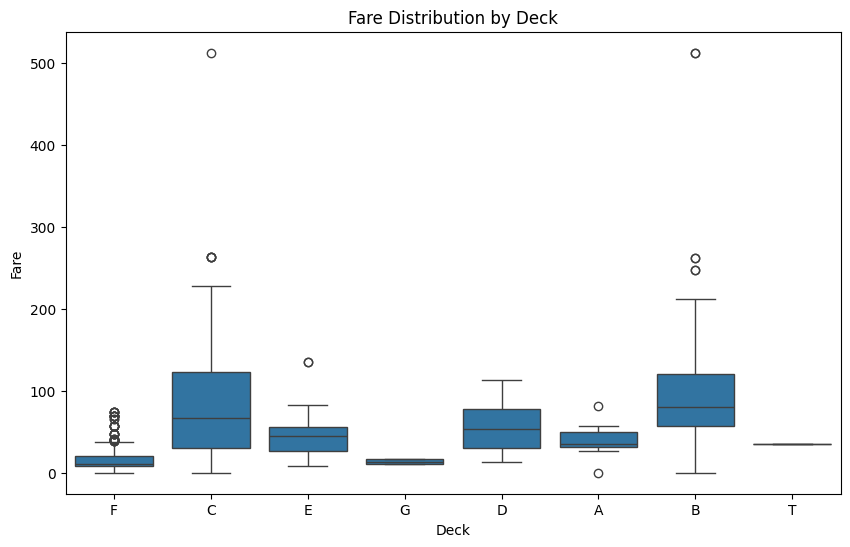

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Deck', y='Fare')
plt.title('Fare Distribution by Deck')
plt.show()

In [11]:
# Create a mapping dictionary
deck_mapping = {
    'B': 2, 'C': 2, 'D': 2,  # High-Class → 2
    'E': 1, 'A': 1,          # Mid-Class → 1
    'F': 0, 'G': 0, 'T': 0   # Low-Class → 0
}

# Map the Deck column to the new categories
df['Deck_Class'] = df['Deck'].map(deck_mapping)
test_df['Deck_Class'] = test_df['Deck'].map(deck_mapping)

# Display the updated dataframe
print(df[['Deck', 'Deck_Class']].head(10))

  Deck  Deck_Class
0    F           0
1    C           2
2    F           0
3    C           2
4    F           0
5    F           0
6    E           1
7    F           0
8    F           0
9    F           0


In [12]:
test_df.drop('Deck', inplace=True, axis=1)
df.drop('Deck', inplace=True, axis=1)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Deck_Class
0,1,0,3,22.0,1,0,7.2500,True,False,True,0
1,2,1,1,38.0,1,0,71.2833,False,False,False,2
2,3,1,3,26.0,0,0,7.9250,False,False,True,0
3,4,1,1,35.0,1,0,53.1000,False,False,True,2
4,5,0,3,35.0,0,0,8.0500,True,False,True,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Sex_male     891 non-null    bool   
 8   Embarked_Q   891 non-null    bool   
 9   Embarked_S   891 non-null    bool   
 10  Deck_Class   891 non-null    int64  
dtypes: bool(3), float64(2), int64(6)
memory usage: 58.4 KB


Binning age and fare.
Binning age and fare helps reduce noise, improve interpretability, capture non-linear or threshold effects, and makes model outputs more actionable—especially when the relationships and data distributions call for it

In [14]:
fare_bins = [0, 10, 50, df['Fare'].max()]
fare_labels = [0, 1, 2]  # Low, Medium, High
test_df['Fare_Bin'] = pd.cut(test_df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
df['Fare_Bin'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin
0,1,0,3,22.0,1,0,7.2500,True,False,True,0,0
1,2,1,1,38.0,1,0,71.2833,False,False,False,2,2
2,3,1,3,26.0,0,0,7.9250,False,False,True,0,0
3,4,1,1,35.0,1,0,53.1000,False,False,True,2,2
4,5,0,3,35.0,0,0,8.0500,True,False,True,0,0


In [15]:
age_bins = [0, 12, 19, 59, df['Age'].max()]
age_labels = [0, 1, 2, 3]  # Child, Teen, Adult, Senior
test_df['Age_Bin'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels)
df['Age_Bin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin,Age_Bin
0,1,0,3,22.0,1,0,7.2500,True,False,True,0,0,2
1,2,1,1,38.0,1,0,71.2833,False,False,False,2,2,2
2,3,1,3,26.0,0,0,7.9250,False,False,True,0,0,2
3,4,1,1,35.0,1,0,53.1000,False,False,True,2,2,2
4,5,0,3,35.0,0,0,8.0500,True,False,True,0,0,2


In [16]:
df.Fare_Bin.value_counts()

Fare_Bin
1    395
0    336
2    160
Name: count, dtype: int64

In [17]:
test_df.drop(['Age', 'Fare'], inplace=True, axis=1)
df.drop(['Age', 'Fare'], inplace=True, axis=1)
df.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin,Age_Bin
0,1,0,3,1,0,True,False,True,0,0,2
1,2,1,1,1,0,False,False,False,2,2,2
2,3,1,3,0,0,False,False,True,0,0,2
3,4,1,1,1,0,False,False,True,2,2,2
4,5,0,3,0,0,True,False,True,0,0,2


Some feature engineering on SubSp and Parch

In [18]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1  # Add 1 to include the passenger themselves
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

# and, we categorize this family size 
df['Family_Group'] = pd.cut(df['Family_Size'], 
                            bins=[0, 1, 4, 7, df['Family_Size'].max()],
                            labels=[0, 1, 2, 3])  # Solo, Small, Medium, Large

test_df['Family_Group'] = pd.cut(test_df['Family_Size'], 
                            bins=[0, 1, 4, 7, test_df['Family_Size'].max()],
                            labels=[0, 1, 2, 3])  # Solo, Small, Medium, Large


test_df.drop(['SibSp', 'Parch', 'Family_Size'], inplace=True, axis=1)
df.drop(['SibSp', 'Parch', 'Family_Size'], inplace=True, axis=1)
test_df.head()

,PassengerId,Pclass,Sex_male,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin,Age_Bin,Family_Group
0,892,3,True,True,False,0,0,2,0
1,893,3,False,False,True,0,0,2,1
2,894,2,True,True,False,0,0,3,0
3,895,3,True,False,True,0,0,2,0
4,896,3,False,False,True,0,1,2,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   891 non-null    int64   
 1   Survived      891 non-null    int64   
 2   Pclass        891 non-null    int64   
 3   Sex_male      891 non-null    bool    
 4   Embarked_Q    891 non-null    bool    
 5   Embarked_S    891 non-null    bool    
 6   Deck_Class    891 non-null    int64   
 7   Fare_Bin      891 non-null    category
 8   Age_Bin       891 non-null    category
 9   Family_Group  891 non-null    category
dtypes: bool(3), category(3), int64(4)
memory usage: 33.7 KB


In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   418 non-null    int64   
 1   Pclass        418 non-null    int64   
 2   Sex_male      418 non-null    bool    
 3   Embarked_Q    418 non-null    bool    
 4   Embarked_S    418 non-null    bool    
 5   Deck_Class    418 non-null    int64   
 6   Fare_Bin      418 non-null    category
 7   Age_Bin       418 non-null    category
 8   Family_Group  418 non-null    category
dtypes: bool(3), category(3), int64(3)
memory usage: 12.9 KB


In [21]:
# saving modelling ready data
df.to_csv("../../data/processed/3-grouped-impute/training_model_ready.csv", index=False)
test_df.to_csv("../../data/processed/3-grouped-impute/testing_model_ready.csv", index=False) 